In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/10243,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/10243,1), 'GB')

Using device: cpu


In [3]:
# Load the demographic data
demo_data = pd.read_csv('demographic_data.csv')
print('Class Frequencies\n',demo_data['TDorSCI'].value_counts())
# Encoding the target variable
demo_data['TDorSCI'] = demo_data['TDorSCI'].map({'TD': 0, 'SCI': 1})
# Load the DTI data
dti_data = pd.read_csv('DTI_data_averaged.csv')

# Merge the two datasets on the 'UID' column
merged_data = demo_data.merge(dti_data, on='UID')

# Fill missing values with -1
filled_data = merged_data.fillna(-1)

# Export filled_data to a CSV file
filled_data.to_csv('PreProcessedData.csv', index=False)

Class Frequencies
 TD     84
SCI    54
Name: TDorSCI, dtype: int64


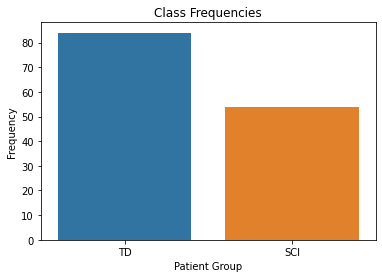

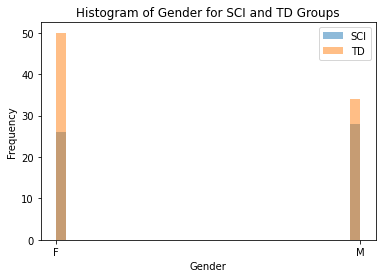

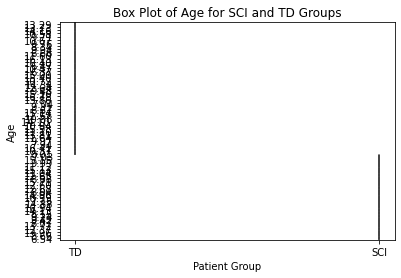

In [4]:
# Separate SCI and TD groups
sci_data = demo_data[demo_data['TDorSCI'] == 1]
td_data = demo_data[demo_data['TDorSCI'] == 0]

# Bar plot of class frequencies
sns.countplot(x='TDorSCI', data=demo_data)
plt.xticks(ticks=[0, 1], labels=['TD', 'SCI'])
plt.xlabel('Patient Group')
plt.ylabel('Frequency')
plt.title('Class Frequencies')
plt.show()

# Histogram of demographic feature
plt.hist(sci_data['Gender'], alpha=0.5, label='SCI', bins=30)
plt.hist(td_data['Gender'], alpha=0.5, label='TD', bins=30)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Histogram of Gender for SCI and TD Groups')
plt.legend(loc='upper right')
plt.show()

# Box plot of demographic feature
sns.boxplot(x='TDorSCI', y='Age', data=demo_data)
plt.xticks(ticks=[0, 1], labels=['TD', 'SCI'])
plt.xlabel('Patient Group')
plt.ylabel('Age')
plt.title('Box Plot of Age for SCI and TD Groups')
plt.show()

In [5]:
# Define the features to be used in the LSTM model
dti_features = ['FA_mean', 'ADC_mean', 'RA_mean', 'MD_mean', 'AD_mean', 'RD_mean']
demo_features = ['Age']

## Data Pre-Processing

In [6]:
#Reshape for PyTorch Model 
grouped_dti_data = filled_data.groupby('UID').apply(lambda x: x[dti_features].astype(float).values.reshape(6, -1))
grouped_demo_data = filled_data.groupby('UID').apply(lambda x: x[demo_features].astype(float).values[0])

# Convert the grouped data to NumPy arrays
X_dti = np.stack(grouped_dti_data.values)
X_demo = np.stack(grouped_demo_data.values)

# Get the labels for each patient, ensuring the same order as X
y = np.array([demo_data.loc[demo_data['UID'] == uid, 'TDorSCI'].iloc[0] for uid in grouped_dti_data.index])

print(X_dti.shape)
print(X_demo.shape)
print(y.shape)


(132, 6, 18)
(132, 1)
(132,)


In [7]:
# Define Dataloader
class SpinalCordDataset(Dataset):
    def __init__(self, X_dti, X_demo, y):
        self.X_dti = X_dti
        self.X_demo = X_demo
        self.y = y

    def __len__(self):
        return len(self.X_dti)

    def __getitem__(self, idx):
        return self.X_dti[idx], self.X_demo[idx], self.y[idx]

In [8]:
batch_size = 32
kf = KFold(n_splits=5, shuffle=True, random_state=42)
split_data = {'train': [], 'validate': [], 'test': []}

for fold, (train_index, test_index) in enumerate(kf.split(X_dti)):
    X_dti_train, X_dti_test = X_dti[train_index], X_dti[test_index]
    X_demo_train, X_demo_test = X_demo[train_index], X_demo[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert the data to PyTorch tensors
    X_dti_train_tensor = torch.tensor(X_dti_train, dtype=torch.float32)
    X_dti_test_tensor = torch.tensor(X_dti_test, dtype=torch.float32)
    X_demo_train_tensor = torch.tensor(X_demo_train, dtype=torch.float32)
    X_demo_test_tensor = torch.tensor(X_demo_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create a dataset
    train_dataset = SpinalCordDataset(X_dti_train_tensor, X_demo_train_tensor, y_train_tensor)
    test_dataset = SpinalCordDataset(X_dti_test_tensor, X_demo_test_tensor, y_test_tensor)

    # Create a data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    if fold < 4:
        split_data['train'].extend(train_dataset)
    elif fold == 4:
        split_data['validate'].extend(train_dataset)
    split_data['test'].extend(test_dataset)

dataloader = {x: DataLoader(split_data[x], batch_size=batch_size,
                            shuffle=True, num_workers=8, drop_last=False) for x in ['train', 'validate', 'test']}


In [9]:
def save_model(model, best_model_wts, train_loss_return,train_acc_return,\
               val_loss_return, val_acc_return, save_name):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, save_name +'.pt')
    return None

In [10]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, scheduler, device, verbose=False, save_name='model1', early_stop_patience=None):
    acc_dict = {'train': [], 'validate': []}
    loss_dict = {'train': [], 'validate': []}
    best_acc = 0
    phases = ['train', 'validate']
    since = time.time()
    y_pred = []
    y_true = []
    stop = False
    best_model_wts = model.state_dict()

    for i in trange(num_epochs):
        if stop:
            break

        print('Epoch: {}/{}'.format(i, num_epochs - 1))
        print('-' * 10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()

            for X_dti, X_demo, label in dataloader[p]:
                optimizer.zero_grad()
                X_dti = X_dti.to(device)
                X_demo = X_demo.to(device)
                label = label.to(device)
                output = model(X_dti, X_demo)
                l1_lambda = 1e-4
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss_fn(output, label) + l1_lambda * l1_norm
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim=1)
                num_imgs = X_dti.size()[0]
                running_correct += torch.sum(preds == label).item()
                running_loss += loss.item() * num_imgs
                running_total += num_imgs
                if p == 'train':
                    loss.backward()
                    optimizer.step()
                if p == 'validate':
                    if i == num_epochs - 1:
                        y_pred += preds.tolist()
                        y_true += label.tolist()

            epoch_acc = float(running_correct / running_total)
            epoch_loss = float(running_loss / running_total)

            if verbose or (i % 10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))

            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                # Update the scheduler at the end of the validation phase
                scheduler.step(epoch_loss)
                
                if early_stop_patience is not None:
                    # Check if the validation accuracy has not improved for `early_stop_patience` epochs
                    if i > early_stop_patience:
                        if all([acc_dict['validate'][j] < acc_dict['validate'][j-early_stop_patience] for j in range(i-early_stop_patience, i+1)]):
                            stop = True
                            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    save_model(model, best_model_wts, loss_dict['train'], acc_dict['train'],
               loss_dict['validate'], acc_dict['validate'], save_name=save_name)

    return model, acc_dict, loss_dict, y_pred, y_true


In [11]:
import torch
import torch.nn as nn

class SpinalCordCNN(nn.Module):
    def __init__(self, num_dti_channels, num_demo_features, num_classes=2):
        super(SpinalCordCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(num_dti_channels, 32, kernel_size=1, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.fc_input_size = self._get_fc_input_size(num_dti_channels)
        
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size + num_demo_features, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, X_dti, X_demo):
        X_dti = self.cnn(X_dti)
        X_dti = X_dti.view(-1, self.fc_input_size)
        X = torch.cat((X_dti, X_demo), dim=1)
        X = self.fc(X)
        return X

    def _get_fc_input_size(self, num_dti_channels):
        dummy_input = torch.randn(1, num_dti_channels, 18)
        dummy_output = self.cnn(dummy_input)
        return dummy_output.view(-1).shape[0]


# 1D-CNN Model Training


In [12]:
num_dti_channels = 6  # Number of input channels for DTI features
num_demo_features = 1  # Number of demographic features
model = SpinalCordCNN(num_dti_channels, num_demo_features)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 50

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [13]:
model, acc_dict, loss_dict, y_pred, y_true = train_model(model.to(device), dataloader, optimizer, 
                                                         criterion, num_epochs, scheduler, device = device, 
                                                         verbose = True, early_stop_patience = 3)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0/49
----------
Phase:train, epoch loss: 0.6795 Acc: 0.6019


  2%|▏         | 1/50 [00:13<10:43, 13.13s/it]

Phase:validate, epoch loss: 0.6718 Acc: 0.6226
Epoch: 1/49
----------
Phase:train, epoch loss: 0.6736 Acc: 0.6019


  4%|▍         | 2/50 [00:25<10:17, 12.86s/it]

Phase:validate, epoch loss: 0.6668 Acc: 0.6226
Epoch: 2/49
----------
Phase:train, epoch loss: 0.6688 Acc: 0.6019


  6%|▌         | 3/50 [00:38<09:59, 12.76s/it]

Phase:validate, epoch loss: 0.6613 Acc: 0.6226
Epoch: 3/49
----------
Phase:train, epoch loss: 0.6647 Acc: 0.6019


  8%|▊         | 4/50 [00:50<09:35, 12.50s/it]

Phase:validate, epoch loss: 0.6563 Acc: 0.6226
Epoch: 4/49
----------
Phase:train, epoch loss: 0.6598 Acc: 0.6019


 10%|█         | 5/50 [01:02<09:12, 12.28s/it]

Phase:validate, epoch loss: 0.6511 Acc: 0.6226
Epoch: 5/49
----------
Phase:train, epoch loss: 0.6539 Acc: 0.6019


 12%|█▏        | 6/50 [01:13<08:46, 11.97s/it]

Phase:validate, epoch loss: 0.6444 Acc: 0.6226
Epoch: 6/49
----------
Phase:train, epoch loss: 0.6469 Acc: 0.6043


 14%|█▍        | 7/50 [01:25<08:32, 11.92s/it]

Phase:validate, epoch loss: 0.6362 Acc: 0.6321
Epoch: 7/49
----------
Phase:train, epoch loss: 0.6377 Acc: 0.6493


 16%|█▌        | 8/50 [01:37<08:25, 12.04s/it]

Phase:validate, epoch loss: 0.6243 Acc: 0.6604
Epoch: 8/49
----------
Phase:train, epoch loss: 0.6238 Acc: 0.6848


 18%|█▊        | 9/50 [01:50<08:19, 12.19s/it]

Phase:validate, epoch loss: 0.6103 Acc: 0.7075
Epoch: 9/49
----------
Phase:train, epoch loss: 0.6104 Acc: 0.7227


 20%|██        | 10/50 [02:03<08:15, 12.39s/it]

Phase:validate, epoch loss: 0.5960 Acc: 0.7453
Epoch: 10/49
----------
Phase:train, epoch loss: 0.5953 Acc: 0.7322


 22%|██▏       | 11/50 [02:15<08:03, 12.40s/it]

Phase:validate, epoch loss: 0.5804 Acc: 0.7547
Epoch: 11/49
----------
Phase:train, epoch loss: 0.5809 Acc: 0.7322


 24%|██▍       | 12/50 [02:28<07:51, 12.39s/it]

Phase:validate, epoch loss: 0.5671 Acc: 0.7547
Epoch: 12/49
----------
Phase:train, epoch loss: 0.5711 Acc: 0.7322


 26%|██▌       | 13/50 [02:40<07:39, 12.43s/it]

Phase:validate, epoch loss: 0.5579 Acc: 0.7547
Epoch: 13/49
----------
Phase:train, epoch loss: 0.5587 Acc: 0.7322


 28%|██▊       | 14/50 [02:52<07:25, 12.37s/it]

Phase:validate, epoch loss: 0.5459 Acc: 0.7453
Epoch: 14/49
----------
Phase:train, epoch loss: 0.5484 Acc: 0.7346


 30%|███       | 15/50 [03:05<07:10, 12.31s/it]

Phase:validate, epoch loss: 0.5369 Acc: 0.7453
Epoch: 15/49
----------
Phase:train, epoch loss: 0.5376 Acc: 0.7441


 32%|███▏      | 16/50 [03:17<06:55, 12.22s/it]

Phase:validate, epoch loss: 0.5285 Acc: 0.7642
Epoch: 16/49
----------
Phase:train, epoch loss: 0.5251 Acc: 0.7559


 34%|███▍      | 17/50 [03:29<06:43, 12.22s/it]

Phase:validate, epoch loss: 0.5173 Acc: 0.7547
Epoch: 17/49
----------
Phase:train, epoch loss: 0.5205 Acc: 0.7559


 36%|███▌      | 18/50 [03:41<06:30, 12.20s/it]

Phase:validate, epoch loss: 0.5086 Acc: 0.7736
Epoch: 18/49
----------
Phase:train, epoch loss: 0.5048 Acc: 0.7654


 38%|███▊      | 19/50 [03:53<06:16, 12.16s/it]

Phase:validate, epoch loss: 0.4979 Acc: 0.7736
Epoch: 19/49
----------
Phase:train, epoch loss: 0.4944 Acc: 0.7607


 40%|████      | 20/50 [04:05<06:02, 12.09s/it]

Phase:validate, epoch loss: 0.4855 Acc: 0.7642
Epoch: 20/49
----------
Phase:train, epoch loss: 0.4823 Acc: 0.7725


 42%|████▏     | 21/50 [04:17<05:51, 12.12s/it]

Phase:validate, epoch loss: 0.4776 Acc: 0.7830
Epoch: 21/49
----------
Phase:train, epoch loss: 0.4679 Acc: 0.7773


 44%|████▍     | 22/50 [04:29<05:41, 12.21s/it]

Phase:validate, epoch loss: 0.4638 Acc: 0.7830
Epoch: 22/49
----------
Phase:train, epoch loss: 0.4600 Acc: 0.7844


 46%|████▌     | 23/50 [04:42<05:28, 12.17s/it]

Phase:validate, epoch loss: 0.4550 Acc: 0.7925
Epoch: 23/49
----------
Phase:train, epoch loss: 0.4440 Acc: 0.7844


 48%|████▊     | 24/50 [04:54<05:18, 12.24s/it]

Phase:validate, epoch loss: 0.4393 Acc: 0.7925
Epoch: 24/49
----------
Phase:train, epoch loss: 0.4343 Acc: 0.7962


 50%|█████     | 25/50 [05:06<05:05, 12.22s/it]

Phase:validate, epoch loss: 0.4245 Acc: 0.7925
Epoch: 25/49
----------
Phase:train, epoch loss: 0.4177 Acc: 0.7962


 52%|█████▏    | 26/50 [05:18<04:49, 12.07s/it]

Phase:validate, epoch loss: 0.4071 Acc: 0.8113
Epoch: 26/49
----------
Phase:train, epoch loss: 0.4026 Acc: 0.8246


 54%|█████▍    | 27/50 [05:30<04:37, 12.05s/it]

Phase:validate, epoch loss: 0.3919 Acc: 0.8302
Epoch: 27/49
----------
Phase:train, epoch loss: 0.3914 Acc: 0.8436


 56%|█████▌    | 28/50 [05:42<04:28, 12.21s/it]

Phase:validate, epoch loss: 0.3777 Acc: 0.8396
Epoch: 28/49
----------
Phase:train, epoch loss: 0.3793 Acc: 0.8341


 58%|█████▊    | 29/50 [05:55<04:16, 12.24s/it]

Phase:validate, epoch loss: 0.3727 Acc: 0.8491
Epoch: 29/49
----------
Phase:train, epoch loss: 0.3818 Acc: 0.8389


 60%|██████    | 30/50 [06:07<04:04, 12.25s/it]

Phase:validate, epoch loss: 0.3579 Acc: 0.8774
Epoch: 30/49
----------
Phase:train, epoch loss: 0.3511 Acc: 0.8578


 62%|██████▏   | 31/50 [06:19<03:50, 12.14s/it]

Phase:validate, epoch loss: 0.3382 Acc: 0.8774
Epoch: 31/49
----------
Phase:train, epoch loss: 0.3384 Acc: 0.8697


 64%|██████▍   | 32/50 [06:31<03:37, 12.07s/it]

Phase:validate, epoch loss: 0.3249 Acc: 0.8868
Epoch: 32/49
----------
Phase:train, epoch loss: 0.3297 Acc: 0.8673


 66%|██████▌   | 33/50 [06:44<03:30, 12.40s/it]

Phase:validate, epoch loss: 0.3087 Acc: 0.8868
Epoch: 33/49
----------
Phase:train, epoch loss: 0.3144 Acc: 0.8697


 68%|██████▊   | 34/50 [06:56<03:16, 12.27s/it]

Phase:validate, epoch loss: 0.2996 Acc: 0.8962
Epoch: 34/49
----------
Phase:train, epoch loss: 0.3054 Acc: 0.8697


 70%|███████   | 35/50 [07:08<03:02, 12.18s/it]

Phase:validate, epoch loss: 0.3178 Acc: 0.8868
Epoch: 35/49
----------
Phase:train, epoch loss: 0.2912 Acc: 0.8768


 72%|███████▏  | 36/50 [07:20<02:49, 12.12s/it]

Phase:validate, epoch loss: 0.2782 Acc: 0.8868
Epoch: 36/49
----------
Phase:train, epoch loss: 0.2839 Acc: 0.8863


 74%|███████▍  | 37/50 [07:32<02:36, 12.03s/it]

Phase:validate, epoch loss: 0.2621 Acc: 0.9057
Epoch: 37/49
----------
Phase:train, epoch loss: 0.2680 Acc: 0.8839


 76%|███████▌  | 38/50 [07:43<02:22, 11.86s/it]

Phase:validate, epoch loss: 0.2595 Acc: 0.8868
Epoch: 38/49
----------
Phase:train, epoch loss: 0.2729 Acc: 0.8791


 78%|███████▊  | 39/50 [07:55<02:10, 11.89s/it]

Phase:validate, epoch loss: 0.2434 Acc: 0.8962
Epoch: 39/49
----------
Phase:train, epoch loss: 0.2525 Acc: 0.8886


 80%|████████  | 40/50 [08:07<01:59, 11.94s/it]

Phase:validate, epoch loss: 0.2304 Acc: 0.9057
Epoch: 40/49
----------
Phase:train, epoch loss: 0.2392 Acc: 0.8863


 82%|████████▏ | 41/50 [08:20<01:49, 12.18s/it]

Phase:validate, epoch loss: 0.2267 Acc: 0.9057
Epoch: 41/49
----------
Phase:train, epoch loss: 0.2312 Acc: 0.8886


 84%|████████▍ | 42/50 [08:33<01:38, 12.31s/it]

Phase:validate, epoch loss: 0.2129 Acc: 0.9057
Epoch: 42/49
----------
Phase:train, epoch loss: 0.2185 Acc: 0.8957


 86%|████████▌ | 43/50 [08:45<01:25, 12.22s/it]

Phase:validate, epoch loss: 0.2182 Acc: 0.9057
Epoch: 43/49
----------
Phase:train, epoch loss: 0.2265 Acc: 0.9100


 88%|████████▊ | 44/50 [08:56<01:12, 12.12s/it]

Phase:validate, epoch loss: 0.2035 Acc: 0.9245
Epoch: 44/49
----------
Phase:train, epoch loss: 0.2033 Acc: 0.8957


 90%|█████████ | 45/50 [09:09<01:00, 12.09s/it]

Phase:validate, epoch loss: 0.1898 Acc: 0.9245
Epoch: 45/49
----------
Phase:train, epoch loss: 0.2065 Acc: 0.9028


 92%|█████████▏| 46/50 [09:21<00:48, 12.20s/it]

Phase:validate, epoch loss: 0.2199 Acc: 0.9151
Epoch: 46/49
----------
Phase:train, epoch loss: 0.2485 Acc: 0.8697


 94%|█████████▍| 47/50 [09:34<00:37, 12.56s/it]

Phase:validate, epoch loss: 0.1809 Acc: 0.9340
Epoch: 47/49
----------
Phase:train, epoch loss: 0.2006 Acc: 0.9100


 96%|█████████▌| 48/50 [09:47<00:25, 12.60s/it]

Phase:validate, epoch loss: 0.1777 Acc: 0.9245
Epoch: 48/49
----------
Phase:train, epoch loss: 0.1830 Acc: 0.9313


 98%|█████████▊| 49/50 [09:59<00:12, 12.47s/it]

Phase:validate, epoch loss: 0.1678 Acc: 0.9434
Epoch: 49/49
----------
Phase:train, epoch loss: 0.1944 Acc: 0.9100


100%|██████████| 50/50 [10:11<00:00, 12.24s/it]

Phase:validate, epoch loss: 0.1828 Acc: 0.9528
Training complete in 10m 12s
Best val acc: 0.952830


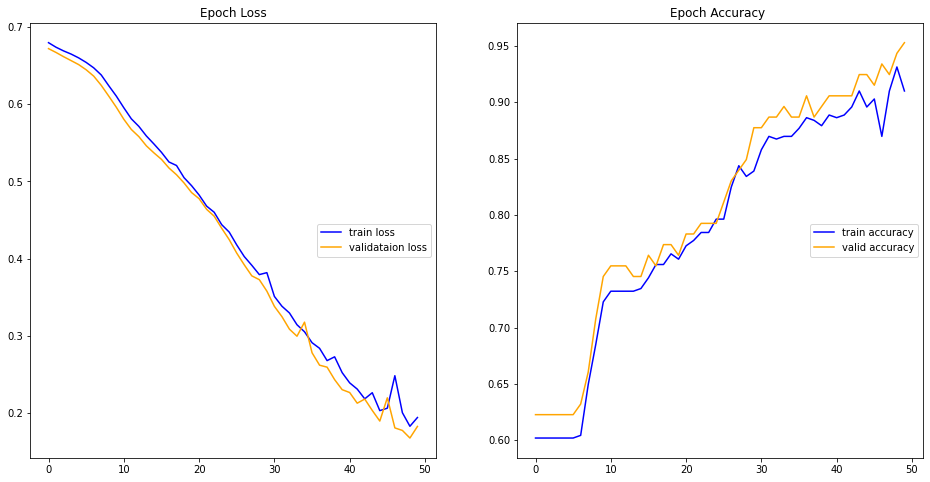

In [25]:
# Plotting loss and accuracy
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(loss_dict['train'], color='blue', label='train loss')
axs[0].plot(loss_dict['validate'], color='orange', label='validataion loss')
axs[1].plot(acc_dict['train'], color = 'blue', label='train accuracy')
axs[1].plot(acc_dict['validate'], color = 'orange', label='valid accuracy')
axs[0].set_title("Epoch Loss")
axs[1].set_title("Epoch Accuracy ")
axs[0].legend(loc='center right')
axs[1].legend(loc='center right')

In [15]:
print('Predicted Class:\n', y_pred[:10])
print('True Class:\n', y_true[:10])

Predicted Class:
 [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True Class:
 [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


## Model Evaluation

In [16]:
def evaluate_model(model, dataloader, loss_fn, device, phase='test'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    y_pred = []  # list of predicted classes
    y_true = []  # list of true classes
    pred_scores_list = []  # list of predicted class probabilities
    outputs = []

    for X_dti, X_demo, label in dataloader[phase]:
        X_dti = X_dti.to(device)
        X_demo = X_demo.to(device)
        label = label.to(device)
        output = model(X_dti, X_demo)
        loss = loss_fn(output, label)
        num_imgs = X_dti.size()[0]
        outputs += output.cpu().detach().numpy().tolist()

        pred_score = nn.Softmax(dim=1)(output).cpu().detach().numpy()
        pred_scores = nn.Softmax(dim=1)(output).cpu().detach().numpy()
        pred_scores_list.append(pred_scores[:, 1])  # Store probabilities of positive class

        _, preds = torch.max(output, dim=1)
        y_true += label.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

        running_correct += torch.sum(preds == label).item()
        running_loss += loss.item() * num_imgs
        running_total += num_imgs

    accuracy = float(running_correct / running_total)
    loss = float(running_loss / running_total)
    print(f'Test Accuracy: {100 * accuracy:.2f}%')

    return accuracy, loss, y_pred, np.array(y_true), np.array([score for sublist in pred_scores_list for score in sublist]), np.array(outputs)


In [26]:
accuracy, loss, y_pred, y_true, pred_scores_list, outputs = evaluate_model(model, dataloader, criterion, device = device, phase='test')

Test Accuracy: 96.21%


Test Accuracy: 96.21%


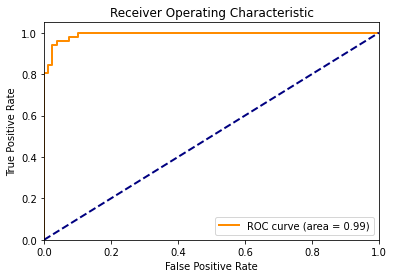

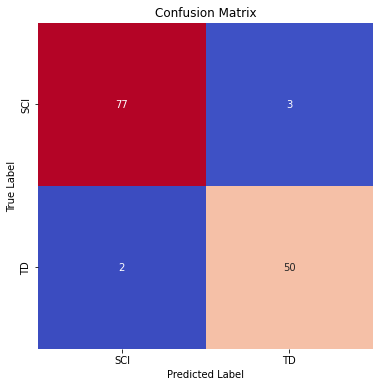

In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
model.eval()
running_correct = 0
running_loss = 0
running_total = 0
y_pred = []  # list of predicted classes
y_true = []  # list of true classes
pred_scores_list = []  # list of predicted class probabilities
outputs = []

for X_dti, X_demo, label in dataloader['test']:
    X_dti = X_dti.to(device)
    X_demo = X_demo.to(device)
    label = label.to(device)
    output = model(X_dti, X_demo)
    loss = criterion(output, label)
    num_imgs = X_dti.size()[0]
    outputs += output.cpu().detach().numpy().tolist()

    pred_score = nn.Softmax(dim=1)(output).cpu().detach().numpy()
    pred_scores = nn.Softmax(dim=1)(output).cpu().detach().numpy()
    pred_scores_list.append(pred_scores[:, 1])  # Store probabilities of positive class

    _, preds = torch.max(output, dim=1)
    y_true += label.cpu().numpy().tolist()
    y_pred += preds.cpu().numpy().tolist()

    running_correct += torch.sum(preds == label).item()
    running_loss += loss.item() * num_imgs
    running_total += num_imgs

accuracy = float(running_correct / running_total)
loss = float(running_loss / running_total)
print(f'Test Accuracy: {100 * accuracy:.2f}%')

predicted_probs = np.concatenate(pred_scores_list)  # Flatten the list of probabilities

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probs]
cm = confusion_matrix(y_true, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="coolwarm", xticklabels=["SCI", "TD"], yticklabels=["SCI", "TD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# Confusion Matrix
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = ['0: TD','1: SCI']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')

Normalized confusion matrix
[[0.96 0.04]
 [0.04 0.96]]


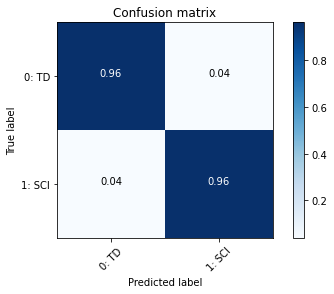

In [20]:
# Plot Confusion Matrix 
cm(y_true, y_pred)

In [21]:
from sklearn.metrics import classification_report, matthews_corrcoef

# Calculate the classification report
report = classification_report(y_true, predicted_labels, target_names=["SCI", "TD"])

# Calculate the classification report
report = classification_report(y_true, predicted_labels, target_names=["SCI", "TD"], output_dict=True)

precision = [report['SCI']['precision'], report['TD']['precision']]
recall = [report['SCI']['recall'], report['TD']['recall']]
f1_score = [report['SCI']['f1-score'], report['TD']['f1-score']]


# Print the classification report
print("Classification Report:")
print(report)

# Calculate the Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, predicted_labels)

# Print the Matthews correlation coefficient
print("Matthews Correlation Coefficient:", mcc)





Classification Report:
{'SCI': {'precision': 0.9746835443037974, 'recall': 0.9625, 'f1-score': 0.9685534591194969, 'support': 80}, 'TD': {'precision': 0.9433962264150944, 'recall': 0.9615384615384616, 'f1-score': 0.9523809523809524, 'support': 52}, 'accuracy': 0.9621212121212122, 'macro avg': {'precision': 0.959039885359446, 'recall': 0.9620192307692308, 'f1-score': 0.9604672057502246, 'support': 132}, 'weighted avg': {'precision': 0.9623582372567326, 'recall': 0.9621212121212122, 'f1-score': 0.9621824716164339, 'support': 132}}
Matthews Correlation Coefficient: 0.9210542974790727


In [22]:
# Calculate the classification report
report = classification_report(y_true, predicted_labels, target_names=["SCI", "TD"], output_dict=True)

precision = [report['SCI']['precision'], report['TD']['precision']]
recall = [report['SCI']['recall'], report['TD']['recall']]
f1_score = [report['SCI']['f1-score'], report['TD']['f1-score']]

# Print the classification report table
print("\\begin{table}[ht]")
print("\\centering")
print("\\begin{tabular}{lccc}")
print("\\hline")
print(" & Precision & Recall & F1 Score \\\\")
print("\\hline")
print("SCI & %0.2f & %0.2f & %0.2f \\\\" % (precision[0], recall[0], f1_score[0]))
print("TD & %0.2f & %0.2f & %0.2f \\\\" % (precision[1], recall[1], f1_score[1]))
print("\\hline")
print("\\end{tabular}")
print("\\caption{Classification Report}")
print("\\label{table:classification_report}")
print("\\end{table}")

# Calculate the Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, predicted_labels)

# Print the Matthews correlation coefficient table
print("\\begin{table}[ht]")
print("\\centering")
print("\\begin{tabular}{lc}")
print("\\hline")
print(" & Matthews Correlation Coefficient \\\\")
print("\\hline")
print(" & %0.2f \\\\" % mcc)
print("\\hline")
print("\\end{tabular}")
print("\\caption{Matthews Correlation Coefficient}")
print("\\label{table:mcc}")
print("\\end{table}")


\begin{table}[ht]
\centering
\begin{tabular}{lccc}
\hline
 & Precision & Recall & F1 Score \\
\hline
SCI & 0.97 & 0.96 & 0.97 \\
TD & 0.94 & 0.96 & 0.95 \\
\hline
\end{tabular}
\caption{Classification Report}
\label{table:classification_report}
\end{table}
\begin{table}[ht]
\centering
\begin{tabular}{lc}
\hline
 & Matthews Correlation Coefficient \\
\hline
 & 0.92 \\
\hline
\end{tabular}
\caption{Matthews Correlation Coefficient}
\label{table:mcc}
\end{table}


In [23]:
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, roc_auc_score, confusion_matrix
from scipy import stats as st

# Calculate the classification report
report = classification_report(y_true, predicted_labels, target_names=["SCI", "TD"], output_dict=True)

precision = [report['SCI']['precision'], report['TD']['precision']]
recall = [report['SCI']['recall'], report['TD']['recall']]
f1_score = [report['SCI']['f1-score'], report['TD']['f1-score']]

# Calculate the Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, predicted_labels)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_true, predicted_labels)

# Calculate the AUC
auc = roc_auc_score(y_true, predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, predicted_labels)
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity with 95% confidence intervals
alpha = 0.05
z = st.norm.ppf(1 - alpha / 2)

sensitivity = tp / (tp + fn)
sens_ci_low = sensitivity - z * np.sqrt(sensitivity * (1 - sensitivity) / (tp + fn))
sens_ci_high = sensitivity + z * np.sqrt(sensitivity * (1 - sensitivity) / (tp + fn))

specificity = tn / (tn + fp)
spec_ci_low = specificity - z * np.sqrt(specificity * (1 - specificity) / (tn + fp))
spec_ci_high = specificity + z * np.sqrt(specificity * (1 - specificity) / (tn + fp))

# Print the classification report table
print("\\begin{table}[ht]")
print("\\centering")
print("\\begin{tabular}{lcccc}")
print("\\hline")
print(" & Precision & Recall & F1 Score & Support \\\\")
print("\\hline")
print("SCI & %0.2f & %0.2f & %0.2f & %d\\\\" % (precision[0], recall[0], f1_score[0], report['SCI']['support']))
print("TD & %0.2f & %0.2f & %0.2f & %d\\\\" % (precision[1], recall[1], f1_score[1], report['TD']['support']))
print("\\hline")
print(" & & & & ")
print("\\end{tabular}")
print("\\caption{Classification Report}")
print("\\label{table:classification_report}")
print("\\end{table}")

# Print the Matthews correlation coefficient table
print("\\begin{table}[ht]")
print("\\centering")
print("\\begin{tabular}{lc}")
print("\\hline")
print(" & Matthews Correlation Coefficient \\\\")
print("\\hline")
print(" & %0.2f \\\\" % mcc)
print("\\hline")
print("\\end{tabular}")
print("\\caption{Matthews Correlation Coefficient}")
print("\\label{table:mcc}")
print("\\end{table}")

# Print the test accuracy, AUC, sensitivity, and specificity table
print("\\begin{table}[ht]")
print("\\centering")
print("\\begin{tabular}{lcc}")
print("\\hline")
print(" & Value & 95\\% CI \\\\")
print("\\hline")
print("Test Accuracy & %0.2f & " % test_accuracy, end='')
print("[%0.2f, %0.2f] \\\\" % (test_accuracy - z * np.sqrt(test_accuracy * (1 - test_accuracy) / len(y_true)),
                               test_accuracy + z * np.sqrt(test_accuracy * (1 - test_accuracy) / len(y_true))))
print("AUC & %0.2f & " % auc, end='')
print("[%0.2f, %0.2f] \\\\" % (auc - z * np.sqrt(auc * (1 - auc) / len(y_true)),
                               auc + z * np.sqrt(auc * (1 - auc) / len(y_true))))
print("Sensitivity & %0.2f & " % sensitivity, end='')
print("[%0.2f, %0.2f] \\\\" % (sens_ci_low, sens_ci_high))
print("Specificity & %0.2f & " % specificity, end='')
print("[%0.2f, %0.2f] \\\\" % (spec_ci_low, spec_ci_high))
print("\\hline")
print("\\end{tabular}")
print("\\caption{Test Metrics}")
print("\\label{table:test_metrics}")
print("\\end{table}")



\begin{table}[ht]
\centering
\begin{tabular}{lcccc}
\hline
 & Precision & Recall & F1 Score & Support \\
\hline
SCI & 0.97 & 0.96 & 0.97 & 80\\
TD & 0.94 & 0.96 & 0.95 & 52\\
\hline
 & & & & 
\end{tabular}
\caption{Classification Report}
\label{table:classification_report}
\end{table}
\begin{table}[ht]
\centering
\begin{tabular}{lc}
\hline
 & Matthews Correlation Coefficient \\
\hline
 & 0.92 \\
\hline
\end{tabular}
\caption{Matthews Correlation Coefficient}
\label{table:mcc}
\end{table}
\begin{table}[ht]
\centering
\begin{tabular}{lcc}
\hline
 & Value & 95\% CI \\
\hline
Test Accuracy & 0.96 & [0.93, 0.99] \\
AUC & 0.96 & [0.93, 0.99] \\
Sensitivity & 0.96 & [0.91, 1.01] \\
Specificity & 0.96 & [0.92, 1.00] \\
\hline
\end{tabular}
\caption{Test Metrics}
\label{table:test_metrics}
\end{table}


In [24]:
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, roc_auc_score
import numpy as np
import scipy.stats as st
from tabulate import tabulate

# Calculate the classification report
report = classification_report(y_true, predicted_labels, target_names=["SCI", "TD"], output_dict=True)

precision = [report['SCI']['precision'], report['TD']['precision']]
recall = [report['SCI']['recall'], report['TD']['recall']]
f1_score = [report['SCI']['f1-score'], report['TD']['f1-score']]

# Calculate the Matthews correlation coefficient
mcc = matthews_corrcoef(y_true, predicted_labels)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_true, predicted_labels)

# Calculate the AUC
auc_score = roc_auc_score(y_true, predicted_labels)

# Calculate sensitivity, specificity, and their confidence intervals
tn, fp, fn, tp = confusion_matrix(y_true, predicted_labels).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Calculate confidence intervals
alpha = 0.05  # 95% confidence interval
z = st.norm.ppf(1 - alpha / 2)

sens_ci_low = sensitivity - z * np.sqrt(sensitivity * (1 - sensitivity) / (tp + fn))
sens_ci_high = sensitivity + z * np.sqrt(sensitivity * (1 - sensitivity) / (tp + fn))

spec_ci_low = specificity - z * np.sqrt(specificity * (1 - specificity) / (tn + fp))
spec_ci_high = specificity + z * np.sqrt(specificity * (1 - specificity) / (tn + fp))

# Create a DataFrame for the classification report
report_df = pd.DataFrame({
    'Measure': ['Test Accuracy', 'AUC', 'Precision (SCI)', 'Precision (TD)', 'Recall (SCI)', 'Recall (TD)', 'F1 Score (SCI)', 'F1 Score (TD)', 'Matthews Correlation Coefficient', 'Sensitivity', 'Sensitivity (95% CI)', 'Specificity', 'Specificity (95% CI)'],
    'Value': [test_accuracy, auc_score, precision[0], precision[1], recall[0], recall[1], f1_score[0], f1_score[1], mcc, sensitivity, f'{sens_ci_low:.2f} - {sens_ci_high:.2f}', specificity, f'{spec_ci_low:.2f} - {spec_ci_high:.2f}'],
}).set_index('Measure')

# Print the publication-ready table using tabulate
print("Publication-ready table:")
print(tabulate(report_df, headers=['Value'], tablefmt='latex_booktabs', numalign='right', floatfmt=".2f"))



Publication-ready table:
\begin{tabular}{ll}
\toprule
                                  & Value              \\
\midrule
 Test Accuracy                    & 0.9621212121212122 \\
 AUC                              & 0.9620192307692308 \\
 Precision (SCI)                  & 0.9746835443037974 \\
 Precision (TD)                   & 0.9433962264150944 \\
 Recall (SCI)                     & 0.9625             \\
 Recall (TD)                      & 0.9615384615384616 \\
 F1 Score (SCI)                   & 0.9685534591194969 \\
 F1 Score (TD)                    & 0.9523809523809524 \\
 Matthews Correlation Coefficient & 0.9210542974790727 \\
 Sensitivity                      & 0.9615384615384616 \\
 Sensitivity (95\% CI)             & 0.91 - 1.01        \\
 Specificity                      & 0.9625             \\
 Specificity (95\% CI)             & 0.92 - 1.00        \\
\bottomrule
\end{tabular}


In [33]:
from sklearn.utils import resample
import numpy as np

def bootstrap_confidence_interval(y_true, y_pred, metric_function, alpha=0.95, n_bootstraps=1000):
    metric_values = []
    
    for _ in range(n_bootstraps):
        resampled_true, resampled_pred = resample(y_true, y_pred)
        metric_value = metric_function(resampled_true, resampled_pred)
        metric_values.append(metric_value)
    
    sorted_metric_values = np.sort(metric_values)
    
    lower_bound = np.percentile(sorted_metric_values, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_metric_values, (1 + alpha) / 2 * 100)
    
    return lower_bound, upper_bound

precision_sci_ci_lower, precision_sci_ci_upper = bootstrap_confidence_interval(y_true, y_pred, lambda yt, yp: precision_score(yt, yp, pos_label=0))
precision_td_ci_lower, precision_td_ci_upper = bootstrap_confidence_interval(y_true, y_pred, lambda yt, yp: precision_score(yt, yp, pos_label=1))
recall_sci_ci_lower, recall_sci_ci_upper = bootstrap_confidence_interval(y_true, y_pred, lambda yt, yp: recall_score(yt, yp, pos_label=0))
recall_td_ci_lower, recall_td_ci_upper = bootstrap_confidence_interval(y_true, y_pred, lambda yt, yp: recall_score(yt, yp, pos_label=1))
f1_sci_ci_lower, f1_sci_ci_upper = bootstrap_confidence_interval(y_true, y_pred, lambda yt, yp: f1_score(yt, yp, pos_label=0))
f1_td_ci_lower, f1_td_ci_upper = bootstrap_confidence_interval(y_true, y_pred, lambda yt, yp: f1_score(yt, yp, pos_label=1))
mcc_ci_lower, mcc_ci_upper = bootstrap_confidence_interval(y_true, y_pred, matthews_corrcoef)


data = [
    ("Test Accuracy", accuracy, "", ""),
    ("AUC", roc_auc, "", ""),
    ("Precision (SCI)", precision_sci, precision_sci_ci_lower, precision_sci_ci_upper),
    ("Precision (TD)", precision_td, precision_td_ci_lower, precision_td_ci_upper),
    ("Recall (SCI)", recall_sci, recall_sci_ci_lower, recall_sci_ci_upper),
    ("Recall (TD)", recall_td, recall_td_ci_lower, recall_td_ci_upper),
    ("F1 Score (SCI)", f1_sci, f1_sci_ci_lower, f1_sci_ci_upper),
    ("F1 Score (TD)", f1_td, f1_td_ci_lower, f1_td_ci_upper),
    ("Matthews Correlation Coefficient", mcc, mcc_ci_lower, mcc_ci_upper),
    # ... (add sensitivity and specificity if needed)
]

from tabulate import tabulate



headers = ["", "Value", "95% CI Lower Bound", "95% CI Upper Bound"]
table = tabulate(data, headers=headers, tablefmt="grid")

print(table)


+----------------------------------+----------+----------------------+----------------------+
|                                  |    Value | 95% CI Lower Bound   | 95% CI Upper Bound   |
+==================================+==========+======================+======================+
| Test Accuracy                    | 0.962121 |                      |                      |
+----------------------------------+----------+----------------------+----------------------+
| AUC                              | 0.993029 |                      |                      |
+----------------------------------+----------+----------------------+----------------------+
| Precision (SCI)                  | 0.974684 | 0.9358870967741936   | 1.0                  |
+----------------------------------+----------+----------------------+----------------------+
| Precision (TD)                   | 0.943396 | 0.875                | 1.0                  |
+----------------------------------+----------+-------------